In [1]:
import pyspark


In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib


     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     --------- --------------------------- 41.0/165.9 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 165.9/165.9 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   -- ------------------------------------- 0.4/8.0 MB 13.5 MB/s eta 0:00:01
   ----- ---------------------------------- 1.1/8.0 MB 17.1 MB/s eta 0:00:01
   ------- -------------------------------- 1.5/8.0 MB 11.9 MB/s eta 0:00:01
   --------- ------------------------------ 2.0/8.0 MB 11.3 MB/s eta 0:00:01
   ------------ --------------------------- 2.5/8.0 MB 12.2 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.0 MB 11.0 MB/s eta 0:00:01
   ----------------- ---------------------- 3.4/8.0 MB 10.9 MB/s eta 0:00:01
   --------------------- ------------------ 4.3/8.0 MB 11.9 MB/s eta 0:00:01
   -----

In [5]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import * # to create a dataframe of a specific type
from pyspark.sql.functions import * # importig SQL functions
from pyspark.sql.window import Window
     

In [8]:
spark = SparkSession.builder.getOrCreate()
spark

In [9]:
spark

In [11]:
data = spark.read.csv("OnlineRetail.csv", inferSchema=True, header=True)

In [12]:
data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [13]:
type(data)

pyspark.sql.dataframe.DataFrame

In [14]:
data.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



In [15]:
data.toPandas().shape

(541909, 8)

In [16]:
data.describe().show()

+-------+-----------------+------------------+--------------------+-----------------+---------------+-----------------+------------------+-----------+
|summary|        InvoiceNo|         StockCode|         Description|         Quantity|    InvoiceDate|        UnitPrice|        CustomerID|    Country|
+-------+-----------------+------------------+--------------------+-----------------+---------------+-----------------+------------------+-----------+
|  count|           541909|            541909|              540455|           541909|         541909|           541909|            406829|     541909|
|   mean| 559965.752026781|27623.240210938104|             20713.0| 9.55224954743324|           NULL| 4.61111362608971|15287.690570239585|       NULL|
| stddev|13428.41728079582|16799.737628427672|                NULL|218.0811578502344|           NULL|96.75985306117953|1713.6003033215968|       NULL|
|    min|           536365|             10002| 4 PURPLE FLOCK D...|           -80995|1/10/2011

In [17]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|       1454|       0|          0|        0|    135080|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [18]:
data.groupBy("Country").count().sort("count", ascending=False).show(10)

+--------------+------+
|       Country| count|
+--------------+------+
|United Kingdom|495478|
|       Germany|  9495|
|        France|  8557|
|          EIRE|  8196|
|         Spain|  2533|
|   Netherlands|  2371|
|       Belgium|  2069|
|   Switzerland|  2002|
|      Portugal|  1519|
|     Australia|  1259|
+--------------+------+
only showing top 10 rows



In [19]:
# Customer distribution by country

rtl_data = data["Country", "CustomerID"].distinct().groupBy("Country").agg(count
          ("CustomerID").alias("Count")).withColumn('Total', sum('Count').over
          (Window.partitionBy())).withColumn('%', (col('Count')/col('Total'))*100).sort("Count", ascending=False)
rtl_data.show(5)

+--------------+-----+-----+------------------+
|       Country|Count|Total|                 %|
+--------------+-----+-----+------------------+
|United Kingdom| 3950| 4380| 90.18264840182648|
|       Germany|   95| 4380|2.1689497716894977|
|        France|   87| 4380|1.9863013698630139|
|         Spain|   31| 4380|0.7077625570776256|
|       Belgium|   25| 4380|0.5707762557077625|
+--------------+-----+-----+------------------+
only showing top 5 rows



In [20]:
# customers from UK
rtl_data = data.filter(col("Country") == "United Kingdom")

rtl_data = rtl_data.filter(col("CustomerID").isNotNull())

print(rtl_data.toPandas().shape)
rtl_data.show(5)
rtl_data.describe().show()

(361878, 8)
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows

+-------+------------------+--------

In [21]:
rtl_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in rtl_data.columns]).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
|        0|        0|          0|       0|          0|        0|         0|      0|
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [22]:
rtl_data.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [23]:
# To remove negative Quantities
rtl_data = rtl_data.filter(col("Quantity") > 0)
# Total Amount column
rtl_data = rtl_data.withColumn("TotalAmount", round(col("Quantity") * col("UnitPrice")))
     

In [24]:
rtl_data.limit(5).toPandas()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.0


In [25]:
rtl_data[rtl_data.Description.isin('WHITE HANGING HEART T-LIGHT HOLDER')].limit(5).show()

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 12/1/2010 8:26|     2.55|     17850|United Kingdom|       15.0|
|   536373|   85123A|WHITE HANGING HEA...|       6| 12/1/2010 9:02|     2.55|     17850|United Kingdom|       15.0|
|   536375|   85123A|WHITE HANGING HEA...|       6| 12/1/2010 9:32|     2.55|     17850|United Kingdom|       15.0|
|   536390|   85123A|WHITE HANGING HEA...|      64|12/1/2010 10:19|     2.55|     17511|United Kingdom|      163.0|
|   536394|   85123A|WHITE HANGING HEA...|      32|12/1/2010 10:39|     2.55|     13408|United Kingdom|       82.0|
+---------+---------+--------------------+--------+---------------+-----

In [26]:
rtl_data[rtl_data.Description.like('%WHITE%')].show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-----------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|       15.0|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|       20.0|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|       20.0|
|   536373|   85123A|WHITE HANGING HEA...|       6|12/1/2010 9:02|     2.55|     17850|United Kingdom|       15.0|
|   536373|    71053| WHITE METAL LANTERN|       6|12/1/2010 9:02|     3.39|     17850|United Kingdom|       20.0|
+---------+---------+--------------------+--------+--------------+---------+----

In [27]:
rtl_data.filter(rtl_data.Quantity > 50000).show()

+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|InvoiceNo|StockCode|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|TotalAmount|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+
|   541431|    23166|MEDIUM CERAMIC TO...|   74215|1/18/2011 10:01|     1.04|     12346|United Kingdom|    77184.0|
|   581483|    23843|PAPER CRAFT , LIT...|   80995| 12/9/2011 9:15|     2.08|     16446|United Kingdom|   168470.0|
+---------+---------+--------------------+--------+---------------+---------+----------+--------------+-----------+



In [28]:
df = rtl_data.toPandas()

In [29]:
print(df.InvoiceDate.min())
print(df.InvoiceDate.max())

1/10/2011 10:32
9/9/2011 9:52


In [30]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [31]:
# calculating the monetary values
monetary =df.groupby("CustomerID").TotalAmount.sum()
monetary = monetary.reset_index() 
monetary.head()

,CustomerID,TotalAmount
0,12346,77184.0
1,12747,4207.0
2,12748,33956.0
3,12749,4115.0
4,12820,946.0


In [32]:
# calculating the frequency values
frequency=df.groupby("CustomerID").InvoiceNo.count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346,1
1,12747,103
2,12748,4596
3,12749,199
4,12820,59


In [33]:
#calculating our recency value
LastDate=df.InvoiceDate.max() #calculating the last date of InvoiceDate
LastDate = LastDate + pd.DateOffset(days=1)
df["Diff"] = LastDate - df.InvoiceDate
recency = df.groupby("CustomerID").Diff.min()
recency = recency.reset_index()
recency.head()

,CustomerID,Diff
0,12346,326 days 02:48:00
1,12747,2 days 22:15:00
2,12748,1 days 00:29:00
3,12749,4 days 02:53:00
4,12820,3 days 21:37:00


In [34]:
rmf = monetary.merge(frequency, on = "CustomerID")
rmf = rmf.merge(recency, on = "CustomerID")
rmf.columns = ["CustomerID", "Monetary", "Frequence", "Recency"]
RMF1 = rmf.drop("CustomerID",axis =1) #dropping customer id and storing it into RMF1
RMF1.Recency = RMF1.Recency.dt.days
RMF1.head()

,Monetary,Frequence,Recency
0,77184.0,1,326
1,4207.0,103,2
2,33956.0,4596,1
3,4115.0,199,4
4,946.0,59,3


In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator

In [37]:
rfm_numbers = spark.read.csv("customer_rfm_numbers.csv", inferSchema=True, header=True)

In [38]:
rfm_numbers.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|     337|
|     17389|      1|        3|    3389|
|   2884871|    171|        5|    1122|
|    394781|     81|        6|      98|
|     98132|     17|        2|    3747|
+----------+-------+---------+--------+
only showing top 5 rows



In [39]:
rfm_numbers_df = rfm_numbers.toPandas()

In [41]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


C:\Users\rajat\AppData\Local\Temp\ipykernel_13556\4156693613.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_numbers_df['Recency'])
C:\Users\rajat\AppData\Local\Temp\ipykernel_13556\4156693613.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_numbers_df['Frequency'])
C:\Users\rajat

<Axes: xlabel='Monetary', ylabel='Density'>

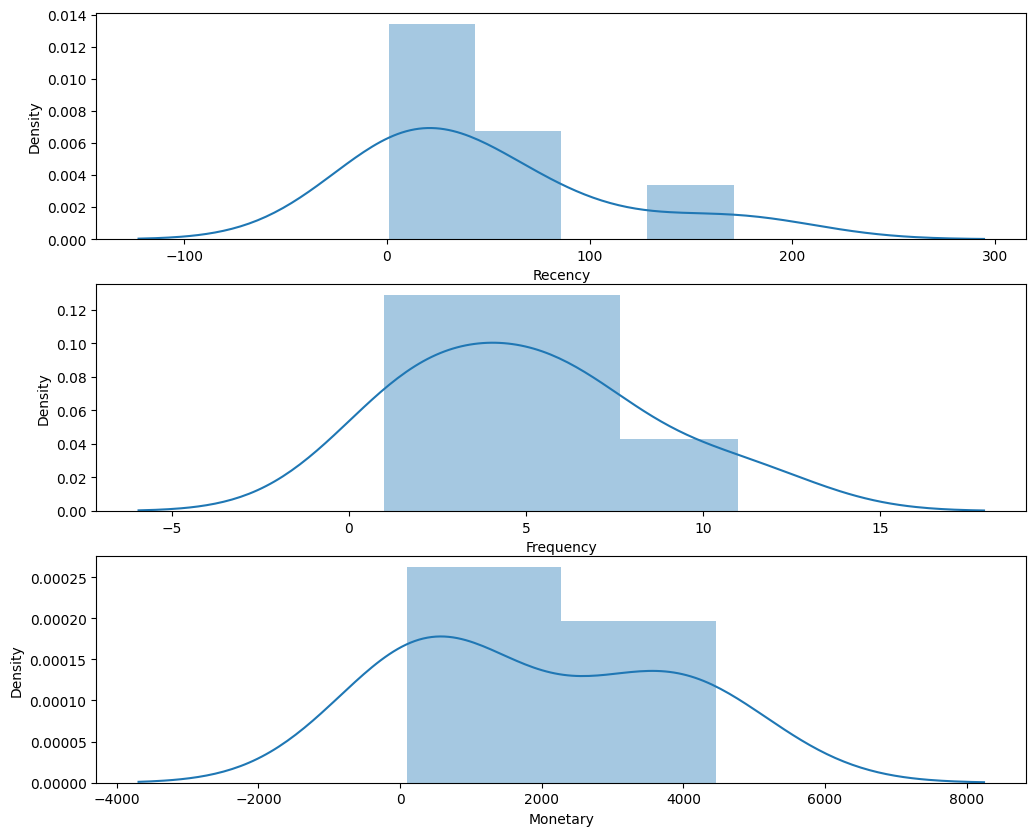

In [42]:
import seaborn as sns
plt.figure(figsize=(12,10))
# Plot distribution of recency
plt.subplot(3, 1, 1)
sns.distplot(rfm_numbers_df['Recency'])
# Plot distribution of frequency
plt.subplot(3, 1, 2)
sns.distplot(rfm_numbers_df['Frequency'])
# Plot distribution of monetary
plt.subplot(3, 1, 3)
sns.distplot(rfm_numbers_df['Monetary'])

In [43]:
# remove zero and negative numbers
rfm_data = (rfm_numbers.withColumn("Monetary", when(col("Monetary") <= 0, 1).otherwise(col("Monetary"))))


In [44]:
features = rfm_data.columns[1:]

In [45]:
rfm_data.show(5)

+----------+-------+---------+--------+
|CustomerID|Recency|Frequency|Monetary|
+----------+-------+---------+--------+
|     15619|     11|        1|     337|
|     17389|      1|        3|    3389|
|   2884871|    171|        5|    1122|
|    394781|     81|        6|      98|
|     98132|     17|        2|    3747|
+----------+-------+---------+--------+
only showing top 5 rows



In [46]:
# vectorize all features
assembler = VectorAssembler(inputCols=features, outputCol="rfm_features")
assembled_data = assembler.transform(rfm_data)
assembled_data = assembled_data.select('CustomerID', 'rfm_features')
assembled_data.show(5)
     

+----------+------------------+
|CustomerID|      rfm_features|
+----------+------------------+
|     15619|  [11.0,1.0,337.0]|
|     17389|  [1.0,3.0,3389.0]|
|   2884871|[171.0,5.0,1122.0]|
|    394781|   [81.0,6.0,98.0]|
|     98132| [17.0,2.0,3747.0]|
+----------+------------------+
only showing top 5 rows



In [47]:
# Standardization 
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')
data_scale = scaler.fit(assembled_data)
scaled_data = data_scale.transform(assembled_data)
scaled_data.show(5)

+----------+------------------+--------------------+
|CustomerID|      rfm_features|    rfm_standardized|
+----------+------------------+--------------------+
|     15619|  [11.0,1.0,337.0]|[0.18112700689788...|
|     17389|  [1.0,3.0,3389.0]|[0.01646609153617...|
|   2884871|[171.0,5.0,1122.0]|[2.81570165268533...|
|    394781|   [81.0,6.0,98.0]|[1.33375341442989...|
|     98132| [17.0,2.0,3747.0]|[0.27992355611491...|
+----------+------------------+--------------------+
only showing top 5 rows



In [48]:
costs = np.zeros(10)
# Apply k-means with different value of k
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('rfm_standardized')
    model = kmeans.fit(scaled_data)
    costs[k] = model.summary.trainingCost

Text(0.5, 1.0, 'Elbow Curve')

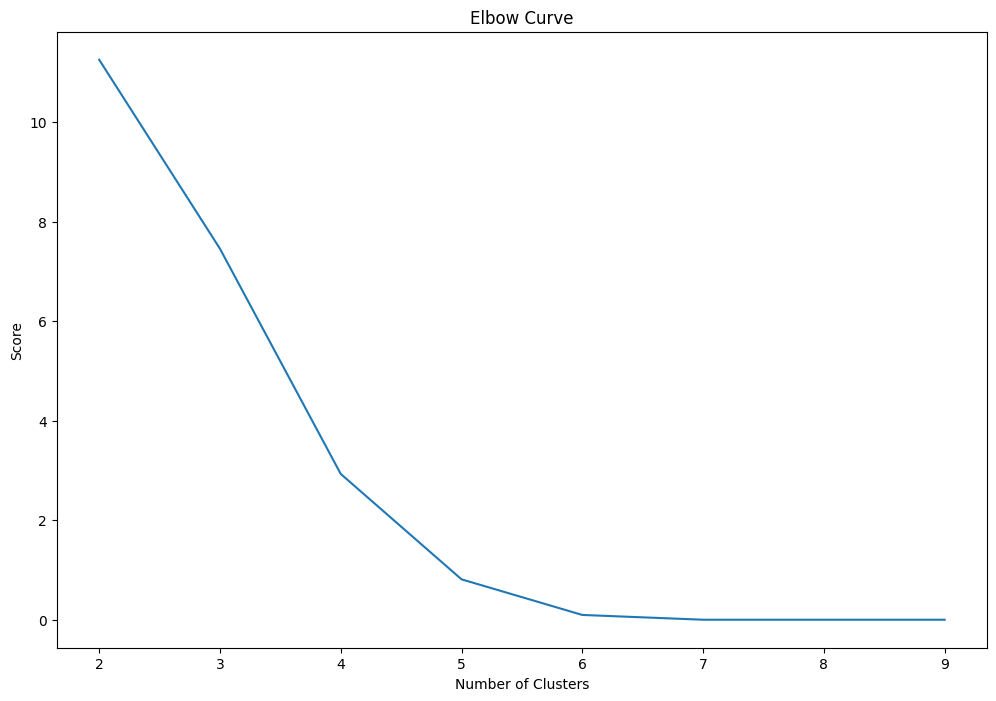

In [49]:
# Plot the cost
df_cost = pd.DataFrame(costs[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8, 9]
df_cost.insert(0, 'cluster', new_col)

fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(df_cost.cluster, df_cost.cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Score')
ax.set_title('Elbow Curve')

In [50]:
k_means = KMeans(featuresCol='rfm_standardized', k=4)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

result = predictions.select('CustomerID', 'prediction')
     

In [51]:
result.show(5)

+----------+----------+
|CustomerID|prediction|
+----------+----------+
|     15619|         1|
|     17389|         2|
|   2884871|         3|
|    394781|         3|
|     98132|         2|
+----------+----------+
only showing top 5 rows



In [53]:
rfm_score = spark.read.csv('retail_loyalty_rfm.csv', inferSchema=True, header=True)
rfm_score = rfm_score.select("CustomerID", "Recency", "Frequency", "Monetary", "Loyalty")
rfm_score.show(5)

+----------+-------+---------+--------+--------+
|CustomerID|Recency|Frequency|Monetary| Loyalty|
+----------+-------+---------+--------+--------+
|     15619|     11|        1|     337|Platinum|
|     17389|      1|        3|    3389|Platinum|
|   2884871|    171|        5|    1122|Platinum|
|    394781|     81|        6|      98|Platinum|
|     98132|     17|        2|    3747|Platinum|
+----------+-------+---------+--------+--------+
only showing top 5 rows



In [54]:
combined_result = result.join(rfm_score, on='CustomerID', how='inner')
     

In [55]:
result = combined_result.toPandas()

In [56]:
import seaborn as sns

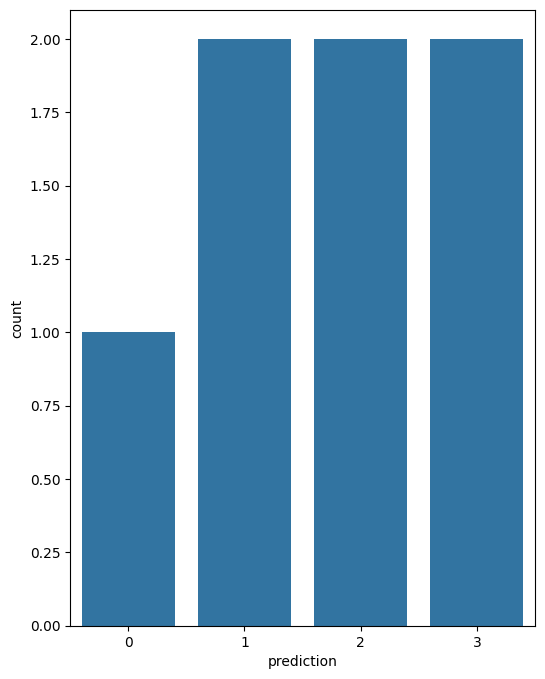

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=result)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

<Axes: xlabel='prediction', ylabel='Monetary'>

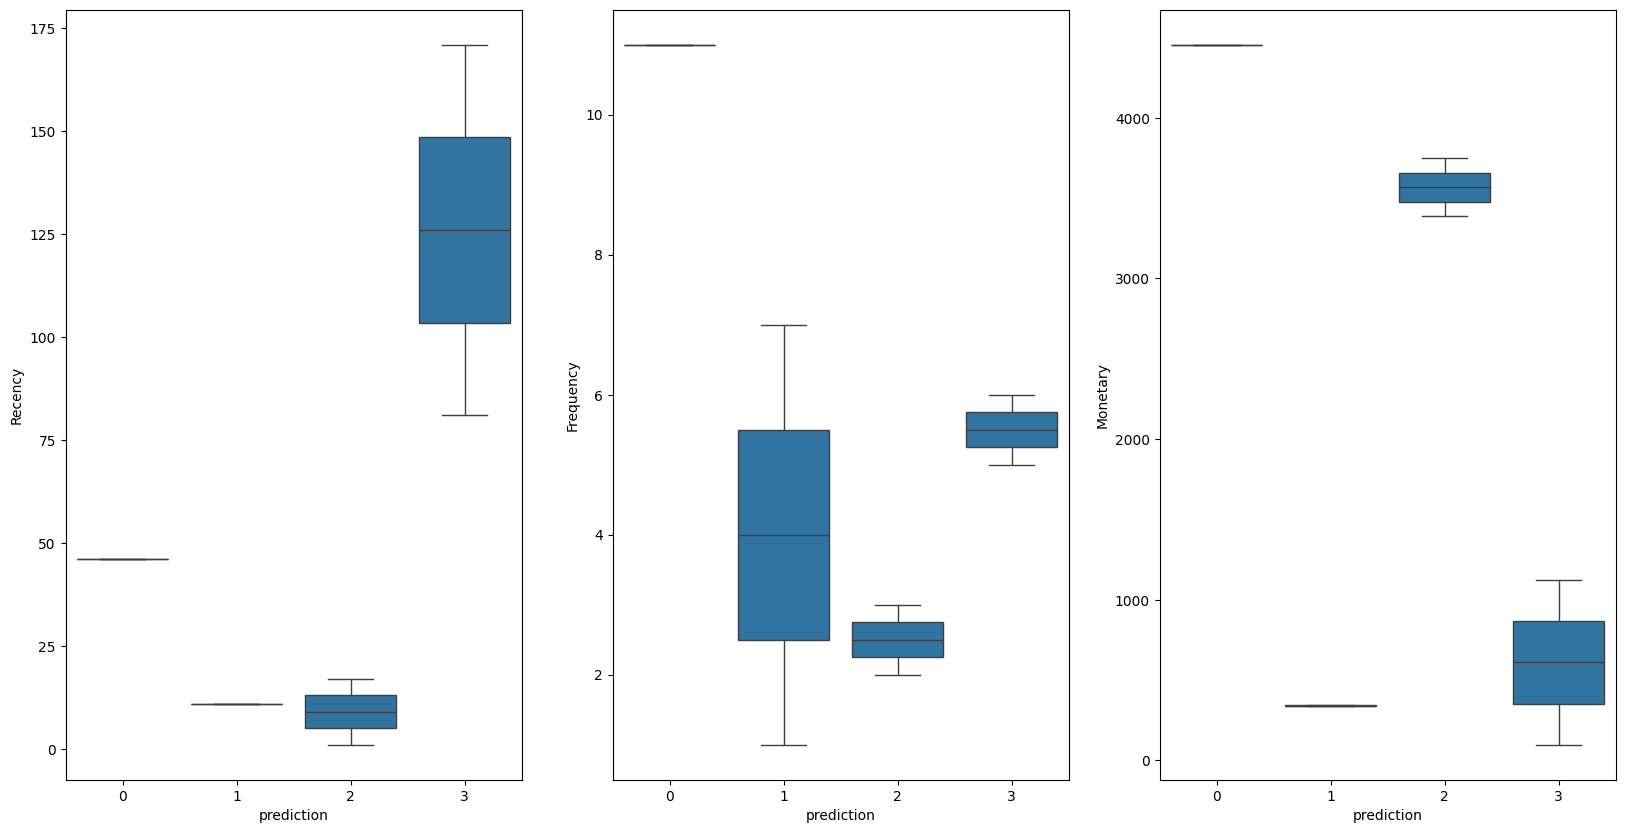

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.boxplot(x='prediction', y='Recency', data=result, ax=ax[0])
sns.boxplot(x='prediction', y='Frequency', data=result, ax=ax[1])
sns.boxplot(x='prediction', y='Monetary', data=result, ax=ax[2])